# Test for single proportions
In Chapter 1, you calculated a p-value for a test hypothesizing that the proportion of late shipments was greater than 6%. In that chapter, you used a bootstrap distribution to estimate the standard error of the statistic. An alternative is to use an equation for the standard error based on the sample proportion, hypothesized proportion, and sample size.

 
 

You'll revisit the p-value using this simpler calculation.

late_shipments is available. pandas and numpy are available under their usual aliases, and norm is loaded from scipy.stats.

* Hypothesize that the proportion of late shipments is 6%.
* Calculate the sample proportion of shipments where late equals "Yes".
* Calculate the number of observations in the sample.

In [1]:
import pandas as pd 

late_shipments = pd.read_feather("/kaggle/input/late-shipments-dataset-to-perform-hypothesis-test/late_shipments.feather")
print(late_shipments)

          id       country managed_by  fulfill_via vendor_inco_term  \
0    36203.0       Nigeria   PMO - US  Direct Drop              EXW   
1    30998.0      Botswana   PMO - US  Direct Drop              EXW   
2    69871.0       Vietnam   PMO - US  Direct Drop              EXW   
3    17648.0  South Africa   PMO - US  Direct Drop              DDP   
4     5647.0        Uganda   PMO - US  Direct Drop              EXW   
..       ...           ...        ...          ...              ...   
995  13608.0        Uganda   PMO - US  Direct Drop              DDP   
996  80394.0    Congo, DRC   PMO - US  Direct Drop              EXW   
997  61675.0        Zambia   PMO - US  Direct Drop              EXW   
998  39182.0  South Africa   PMO - US  Direct Drop              DDP   
999   5645.0      Botswana   PMO - US  Direct Drop              EXW   

    shipment_mode  late_delivery late product_group    sub_classification  \
0             Air            1.0  Yes          HRDT              HIV t

In [2]:
# Hypothesize that the proportion of late shipments is 6%
p_0 = 0.06

# Calculate the sample proportion of late shipments
p_hat = (late_shipments['late'] == "Yes").mean()

# Calculate the sample size
n = len(late_shipments)

# Print p_hat and n
print(p_hat, n)

0.061 1000


* Calculate the numerator and denominator of the z-score.
* Calculate the z-score as the ratio of these numbers.

In [4]:
import numpy as np

# Calculate the numerator and denominator of the test statistic
numerator = p_hat -p_0
denominator = np.sqrt(p_0 * (1-p_0) / n)

# Calculate the test statistic
z_score = numerator / denominator

# Print the result
print(z_score)

0.13315591032282698


* Transform the z-score into a p-value, remembering that this is a "greater than" alternative hypothesis.

In [6]:
from scipy.stats import norm

# Calculate the p-value from the z-score
p_value = 1 - norm.cdf(z_score)

# Print the p-value
print(p_value)

0.44703503936503364


While bootstrapping can be used to estimate the standard error of any statistic, it is computationally intensive. For proportions, using a simple equation of the hypothesized proportion and sample size is easier to compute.

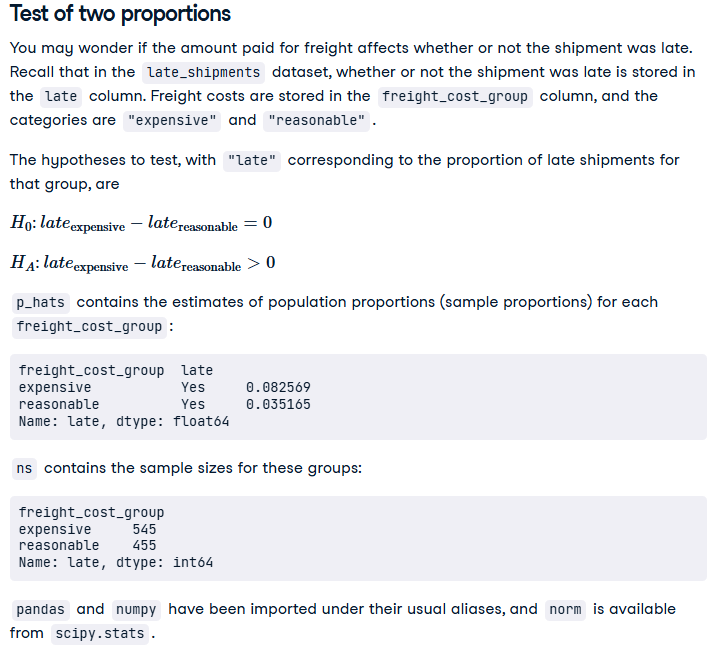

* Calculate the p-value from the z-score.

In [12]:
# Calculate the sample proportions (p_hats) for each freight_cost_group
p_hats = late_shipments.groupby('freight_cost_groups')['late'].value_counts(normalize=True).unstack()['Yes']

# Calculate the sample sizes (ns) for each freight_cost_group
ns = late_shipments.groupby('freight_cost_groups')['late'].count()

# Print the results to verify
print("Sample proportions (p_hats):")
print(p_hats)
print("\nSample sizes (ns):")
print(ns)


Sample proportions (p_hats):
freight_cost_groups
expensive     0.079096
reasonable    0.035165
Name: Yes, dtype: float64

Sample sizes (ns):
freight_cost_groups
expensive     531
reasonable    455
Name: late, dtype: int64


In [13]:
# Calculate the pooled estimate of the population proportion
p_hat = (p_hats["reasonable"] * ns["reasonable"] + p_hats["expensive"] * ns["expensive"]) / (ns["reasonable"] + ns["expensive"])
# Print the result
print(p_hat)

0.058823529411764705


* Calculate p_hat multiplied by (1 - p_hat).
* Divide p_hat_times_not_p_hat by the number of "reasonable" rows and by the number of "expensive" rows, and sum those two values.
* Calculate std_error by taking the square root of p_hat_times_not_p_hat_over_ns.

### Calculate the standard error of the sample using this equation.

 
 

* Calculate p_hat multiplied by (1 - p_hat).
* Divide p_hat_times_not_p_hat by the number of "reasonable" rows and by the number of "expensive" rows, and sum those two values.
* Calculate std_error by taking the square root of p_hat_times_not_p_hat_over_ns.

In [14]:
# Calculate p_hat one minus p_hat
p_hat_times_not_p_hat = p_hat * (1 - p_hat)

# Divide this by each of the sample sizes and then sum
p_hat_times_not_p_hat_over_ns = p_hat_times_not_p_hat / ns["expensive"] + p_hat_times_not_p_hat / ns["reasonable"]
# Calculate the standard error
std_error = np.sqrt(p_hat_times_not_p_hat_over_ns)

# Print the result
print(std_error)

0.015031300895066685


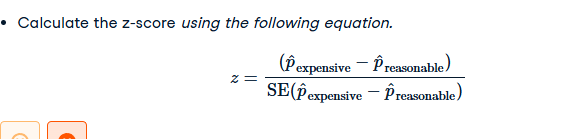

In [15]:
# Calculate the z-score
z_score = (p_hats["expensive"] - p_hats["reasonable"]) / std_error
# Print z_score
print(z_score)

2.922648567784529


* Calculate the p-value from the z-score.



In [16]:
# Calculate the p-value from the z-score
p_value = 1 - norm.cdf(z_score)

# Print p_value
print(p_value)

0.0017353400023595311


You can calculate a p-value for a two sample proportion test using (a rather exhausting amount of) arithmetic. This tiny p-value leads us to suspect there is a larger proportion of late shipments for expensive freight compared to reasonable freight

## proportions_ztest() for two samples
That took a lot of effort to calculate the p-value, so while it is useful to see how the calculations work, it isn't practical to do in real-world analyses. For daily usage, it's better to use the statsmodels package.

Recall the hypotheses.

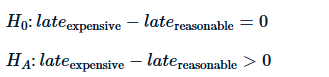

late_shipments is available, containing the freight_cost_group column. numpy and pandas have been loaded under their standard aliases, and proportions_ztest has been loaded from statsmodels.stats.proportion.


* Get the counts of the late column grouped by freight_cost_group.

In [18]:
# Count the late column values for each freight_cost_group
late_by_freight_cost_group = late_shipments.groupby("freight_cost_groups")["late"].value_counts()

# Print the counts
print(late_by_freight_cost_group)

freight_cost_groups  late
expensive            No      489
                     Yes      42
reasonable           No      439
                     Yes      16
Name: count, dtype: int64


* Extract the number of "Yes"'s for the two freight_cost_group into a numpy array, specifying the 'expensive' count and then 'reasonable'.
* Determine the overall number of rows in each freight_cost_group as a numpy array, specifying the 'expensive' count and then 'reasonable'.
* Run a z-test using proportions_ztest(), specifying alternative as "larger"

In [20]:
from statsmodels.stats.proportion import proportions_ztest

# Count the late column values for each freight_cost_group
late_by_freight_cost_group = late_shipments.groupby("freight_cost_groups")['late'].value_counts()

# Create an array of the "Yes" counts for each freight_cost_group
success_counts = np.array([42, 16])

# Create an array of the total number of rows in each freight_cost_group
n = np.array([489+42, 439+16])

# Run a z-test on the two proportions
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative="larger")


# Print the results
print(stat, p_value)

2.922648567784529 0.001735340002359578


Delightful déjà vu! statsmodels's .proportions_ztest() method gives the same results with less effort.

# The chi-square distribution
Chi-square hypothesis tests rely on the chi-square distribution. Like the t-distribution, it has degrees of freedom and non-centrality parameters.

The plots show the PDF and CDF for a chi-square distribution (solid black line), and for comparison show a normal distribution with the same mean and variance (gray dotted line).

Which statement about the chi-square distribution is true?

* As you increase the degrees of freedom or the non-centrality, the chi-square distribution PDF and CDF curves get closer to those of a normal distribution.

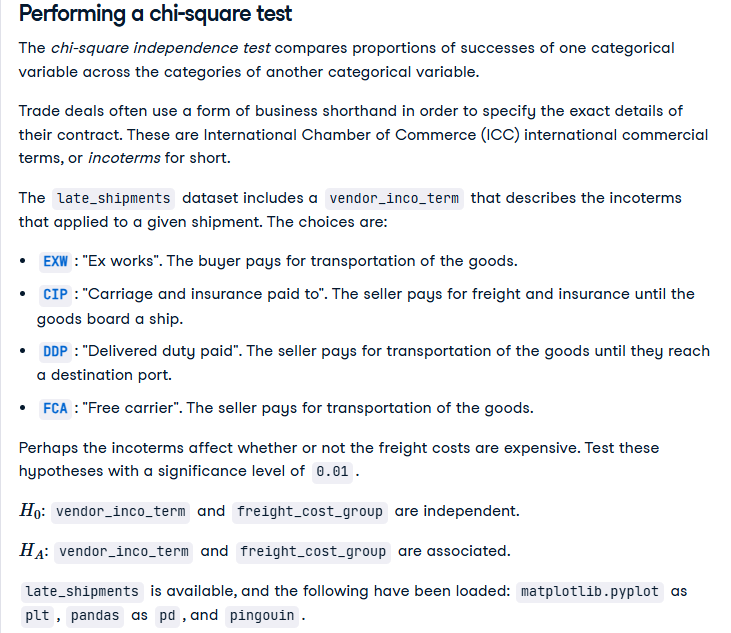

* Calculate the proportion of freight_cost_group in late_shipments grouped by vendor_inco_term
* Unstack the .value_counts() result to be in wide format instead of long.
* Create a proportional stacked bar plot with bars filled based on freight_cost_group across the levels of vendor_inco_term.
* Perform a chi-square test of independence on freight_cost_group and vendor_inco_term in the late_shipments dataset.
* 

In [22]:
# Proportion of freight_cost_group grouped by vendor_inco_term
props = late_shipments.groupby('vendor_inco_term')['freight_cost_groups'].value_counts(normalize=True)

# Print props
print(props)

vendor_inco_term  freight_cost_groups
CIP               reasonable             0.680000
                  expensive              0.320000
DDP               expensive              0.550000
                  reasonable             0.450000
DDU               reasonable             1.000000
EXW               expensive              0.583448
                  reasonable             0.416552
FCA               reasonable             0.663636
                  expensive              0.336364
Name: proportion, dtype: float64


In [23]:
# Convert props to wide format
wide_props = props.unstack()

# Print wide_props
print(wide_props)

freight_cost_groups  expensive  reasonable
vendor_inco_term                          
CIP                   0.320000    0.680000
DDP                   0.550000    0.450000
DDU                        NaN    1.000000
EXW                   0.583448    0.416552
FCA                   0.336364    0.663636


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


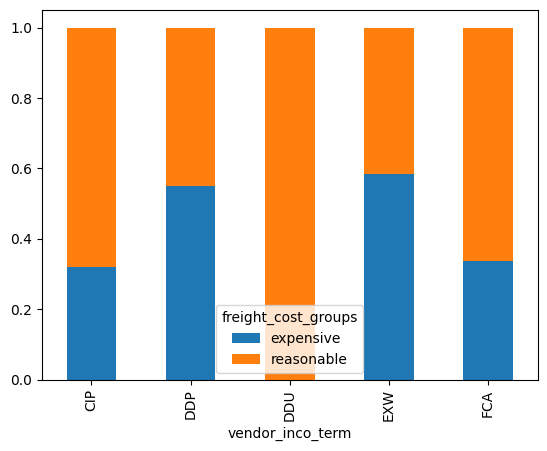

In [27]:
import matplotlib.pyplot as plt

# Proportion of freight_cost_group grouped by vendor_inco_term
props = late_shipments.groupby('vendor_inco_term')['freight_cost_groups'].value_counts(normalize=True)

wide_props.plot(kind="bar", stacked=True)

plt.show()

In [30]:
pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.0 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


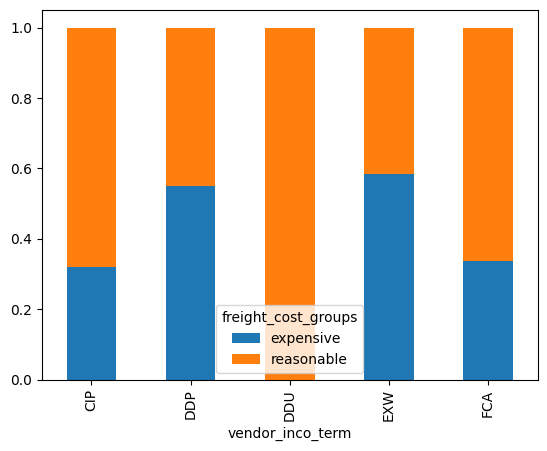

AssertionError: columns are not in dataframe.

In [31]:
import pingouin

# Proportion of freight_cost_group grouped by vendor_inco_term
props = late_shipments.groupby('vendor_inco_term')['freight_cost_groups'].value_counts(normalize=True)

# Convert props to wide format
wide_props = props.unstack()

# Proportional stacked bar plot of freight_cost_group vs. vendor_inco_term
wide_props.plot(kind="bar", stacked=True)
plt.show()

# Determine if freight_cost_group and vendor_inco_term are independent
expected, observed, stats = pingouin.chi2_independence(data=late_shipments, x="vendor_inco_term", y="freight_cost_group")

# Print results
print(stats[stats['test'] == 'pearson']) 

Reject the null hypothesis and conclude that vendor_inco_term and freight_cost_group are associated.

Independence insight! The test to compare proportions of successes in a categorical variable across groups of another categorical variable is called a chi-square test of independence.


# Visualizing goodness of fit
The chi-square goodness of fit test compares proportions of each level of a categorical variable to hypothesized values. Before running such a test, it can be helpful to visually compare the distribution in the sample to the hypothesized distribution.

Recall the vendor incoterms in the late_shipments dataset. You hypothesize that the four values occur with these frequencies in the population of shipments.

* CIP: 0.05
* DDP: 0.1
* EXW: 0.75
* FCA: 0.1
These frequencies are stored in the hypothesized DataFrame.

The incoterm_counts DataFrame stores the .value_counts() of the vendor_inco_term column.

late_shipments is available; pandas and matplotlib.pyplot are loaded with their standard aliases.

* Find the total number of rows in late_shipments.
* Add a column named n to the hypothesized DataFrame that is the hypothesized prop column times n_total.
* Create a bar graph of 'n' versus 'vendor_inco_term' for the incoterm_counts data, specifying a red color.
* Add blue bars to the plot showing the same results from the hypothesized DataFrame, specifying an alpha of 0.5.



In [32]:
# Find the number of rows in late_shipments
n_total = len(late_shipments)

# Print n_total
print(n_total)

1000


In [34]:
# Create the hypothesized DataFrame with the specified frequencies
hypothesized = pd.DataFrame({
    'vendor_inco_term': ['CIP', 'DDP', 'EXW', 'FCA'],
    'hypothesized_proportion': [0.05, 0.1, 0.75, 0.1]
})

# Set the vendor_inco_term as the index for easier comparison
hypothesized = hypothesized.set_index('vendor_inco_term')

# Print the hypothesized DataFrame
print("Hypothesized proportions:")
print(hypothesized)

Hypothesized proportions:
                  hypothesized_proportion
vendor_inco_term                         
CIP                                  0.05
DDP                                  0.10
EXW                                  0.75
FCA                                  0.10


Hypothesized proportions:
                  prop
vendor_inco_term      
CIP               0.05
DDP               0.10
EXW               0.75
FCA               0.10

Actual counts:
vendor_inco_term
EXW    732
FCA    111
DDP    100
CIP     56
DDU      1
Name: count, dtype: int64

Total number of shipments: 1000

Hypothesized expected counts:
                  prop      n
vendor_inco_term             
CIP               0.05   50.0
DDP               0.10  100.0
EXW               0.75  750.0
FCA               0.10  100.0

Comparison of actual vs hypothesized proportions:
                  actual_prop  hypothesized_prop
vendor_inco_term                                
CIP                     0.056               0.05
DDP                     0.100               0.10
DDU                     0.001               0.00
EXW                     0.732               0.75
FCA                     0.111               0.10


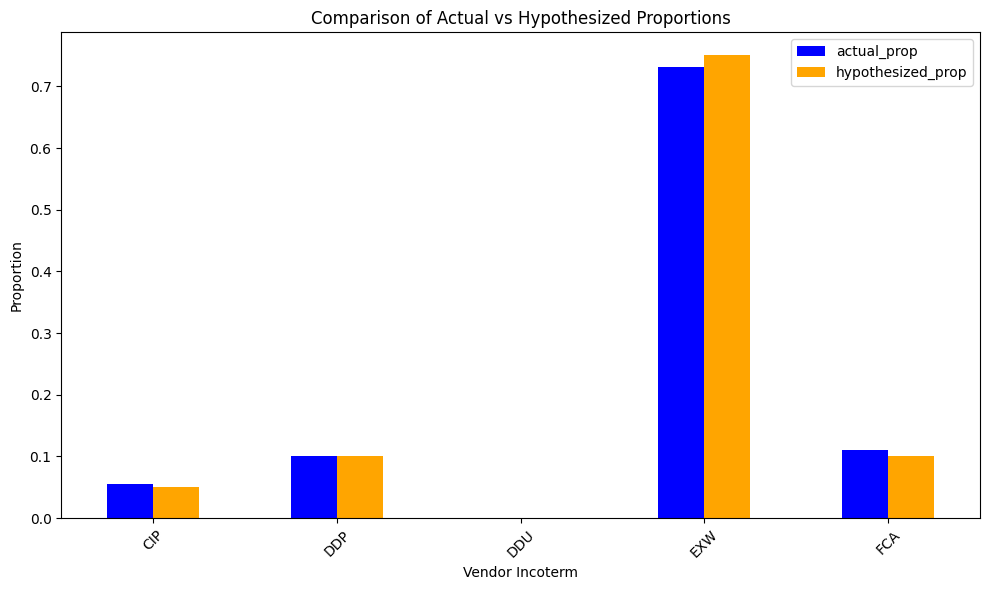

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Create the hypothesized DataFrame with the correct column names
hypothesized = pd.DataFrame({
    'vendor_inco_term': ['CIP', 'DDP', 'EXW', 'FCA'],
    'prop': [0.05, 0.1, 0.75, 0.1]  # This should be the column name you're trying to access
})

# Set the vendor_inco_term as the index for easier comparison
hypothesized = hypothesized.set_index('vendor_inco_term')

# Print the hypothesized DataFrame
print("Hypothesized proportions:")
print(hypothesized)

# Now let's get the actual counts from the late_shipments dataset
incoterm_counts = late_shipments['vendor_inco_term'].value_counts()
n_total = len(late_shipments)

print("\nActual counts:")
print(incoterm_counts)
print(f"\nTotal number of shipments: {n_total}")

# Create n column that is prop column * n_total
hypothesized["n"] = hypothesized["prop"] * n_total

# Print the modified hypothesized DataFrame
print("\nHypothesized expected counts:")
print(hypothesized)

# Create a comparison DataFrame for visualization
actual_proportions = late_shipments['vendor_inco_term'].value_counts(normalize=True)
comparison = pd.DataFrame({
    'actual_prop': actual_proportions,
    'hypothesized_prop': hypothesized['prop']
}).fillna(0)  # Fill any missing values with 0

print("\nComparison of actual vs hypothesized proportions:")
print(comparison)

# Visualize the comparison
fig, ax = plt.subplots(figsize=(10, 6))
comparison.plot(kind='bar', ax=ax, color=['blue', 'orange'])
ax.set_title('Comparison of Actual vs Hypothesized Proportions')
ax.set_ylabel('Proportion')
ax.set_xlabel('Vendor Incoterm')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [38]:
# Find the number of rows in late_shipments
n_total = len(late_shipments)

# Create n column that is prop column * n_total
hypothesized["n"] = hypothesized["prop"] * n_total

# Plot a red bar graph of n vs. vendor_inco_term for incoterm_counts
plt.bar(incoterm_counts['vendor_inco_term'], incoterm_counts['n'], label="Observed", color ='red')
plt.legend()
plt.show()

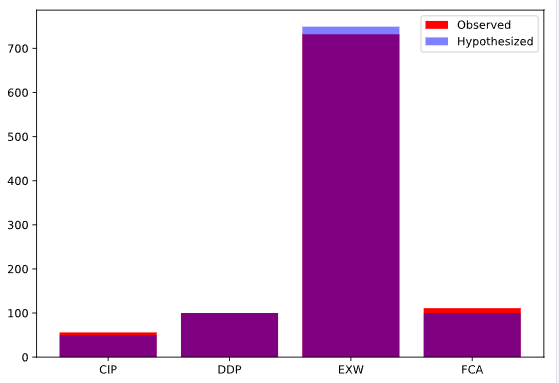

In [ ]:
# Find the number of rows in late_shipments
n_total = len(late_shipments)

# Create n column that is prop column * n_total
hypothesized["n"] = hypothesized["prop"] * n_total

# Plot a red bar graph of n vs. vendor_inco_term for incoterm_counts
plt.bar(incoterm_counts['vendor_inco_term'], incoterm_counts['n'], color="red", label="Observed")

# Add a blue bar plot for the hypothesized counts
plt.bar(hypothesized['vendor_inco_term'], hypothesized['n'], alpha=0.5, color="blue", label="Hypothesized")

plt.legend()
plt.show()

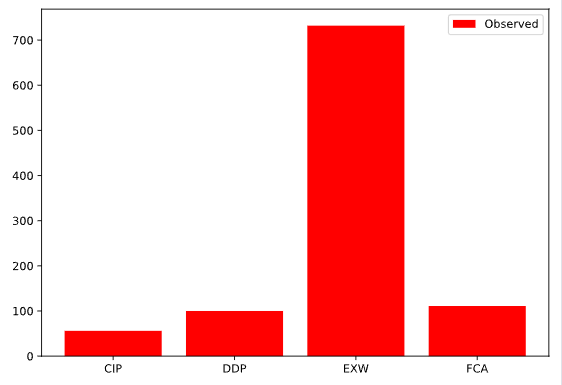

Beautiful bars! Two of the bars in the sample are very close to the hypothesized values: one is a little high and one is a little low. Head on over to the next exercise to test if these differences are statistically significant.

## Performing a goodness of fit test
The bar plot of vendor_inco_term suggests that the distribution across the four categories was quite close to the hypothesized distribution. You'll need to perform a chi-square goodness of fit test to see whether the differences are statistically significant.

Recall the hypotheses for this type of test:

H0 : The sample matches with the hypothesized distribution.

H1 : The sample does not match with the hypothesized distribution.

To decide which hypothesis to choose, we'll set a significance level of 0.1.

late_shipments, incoterm_counts, and hypothesized from the last exercise are available. chisquare from scipy.stats has been loaded.


* Using the incoterm_counts and hypothesized datasets, perform a chi-square goodness of fit test on the incoterm counts, n.




In [41]:
from scipy.stats import chisquare

# Perform a goodness of fit test on the incoterm counts n
gof_test = chisquare(f_obs=incoterm_counts['n'], 
                     f_exp=hypothesized['n'])

# Print gof_test results
print(gof_test)

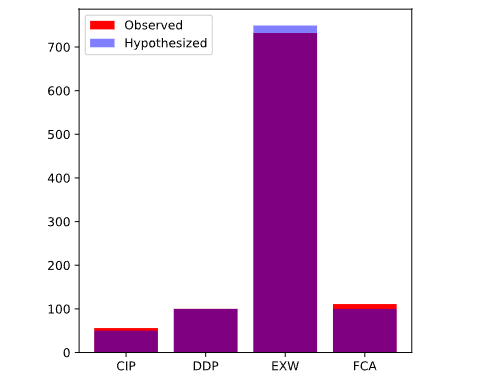